<a href="https://colab.research.google.com/github/leticiarccorrea/Modelos-machine-learning/blob/main/preventfail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

nome: leticia_correa

email: leticiarccorrea@gmail.com

github:https://github.com/leticiarccorrea

In [140]:
#import dataset

from google.colab import drive
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# Access to Google Drive
drive.mount('/content/drive')
datapah = '/content/drive/MyDrive/caseshape/O_G_Equipment_Data.xlsx'

# Load file in pandas and spark
base_pd = pd.read_excel(datapah)
base = spark.createDataFrame(base_pd)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
#import the libraries

# view
import matplotlib.pyplot as plt
import seaborn as sns

# analyses
import pandas as pd
import numpy as np
from scipy import stats
import ast
import string
import warnings
import os

# Spark
from pyspark.sql import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import lit, col
from pyspark.sql.types import StringType

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    precision_recall_fscore_support
)
from xgboost import XGBClassifier
import shap


In [142]:
base.show()


+-----+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+-----+
|Cycle|Preset_1|Preset_2|       Temperature|          Pressure|        VibrationX|        VibrationY|        VibrationZ|         Frequency| Fail|
+-----+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+-----+
|    1|       3|       6| 44.23518586415284| 47.65725354833926| 46.44176923068589| 64.82032657891138| 66.45451956495226| 44.48324980824037|false|
|    2|       2|       4|60.807234448796294| 63.17207576842222| 62.00595106708013| 80.71443106372683|  81.2464046543589|60.228714793422036|false|
|    3|       2|       1| 79.02753565280922| 83.03218967065293| 82.64210959422543|  98.2543855725768| 98.78519593981386| 80.99347914594966|false|
|    4|       2|       3| 79.71624156697328| 100.5086344886615|122.36232148005857|121.36342870189367|118.65253755569158| 80.

In [143]:
base.count()

800




Df description of the features:

1.	Cycle: Sequential identifier of measurement cycles.

2.	Preset_1 & Preset_2: Variables that control a specific operating point of the machine.

3.	Temperature: Temperature recorded in the equipment.

4.	Vibrations (X, Y & Z): Vibrations along the machine's axes.

5.	Frequency: Operating frequency of the machine.

6.	Fail: Variable indicating whether the machine is in a failure state at the given timestamp.


**Dataset cleaning and exploration**

In [144]:
base.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in base.columns
]).show()

# no null values

+-----+--------+--------+-----------+--------+----------+----------+----------+---------+----+
|Cycle|Preset_1|Preset_2|Temperature|Pressure|VibrationX|VibrationY|VibrationZ|Frequency|Fail|
+-----+--------+--------+-----------+--------+----------+----------+----------+---------+----+
|    0|       0|       0|          0|       0|         0|         0|         0|        0|   0|
+-----+--------+--------+-----------+--------+----------+----------+----------+---------+----+



In [145]:
# dataset features

num_cols = ["Temperature", "Pressure", "VibrationX", "VibrationY", "VibrationZ", "Frequency"]


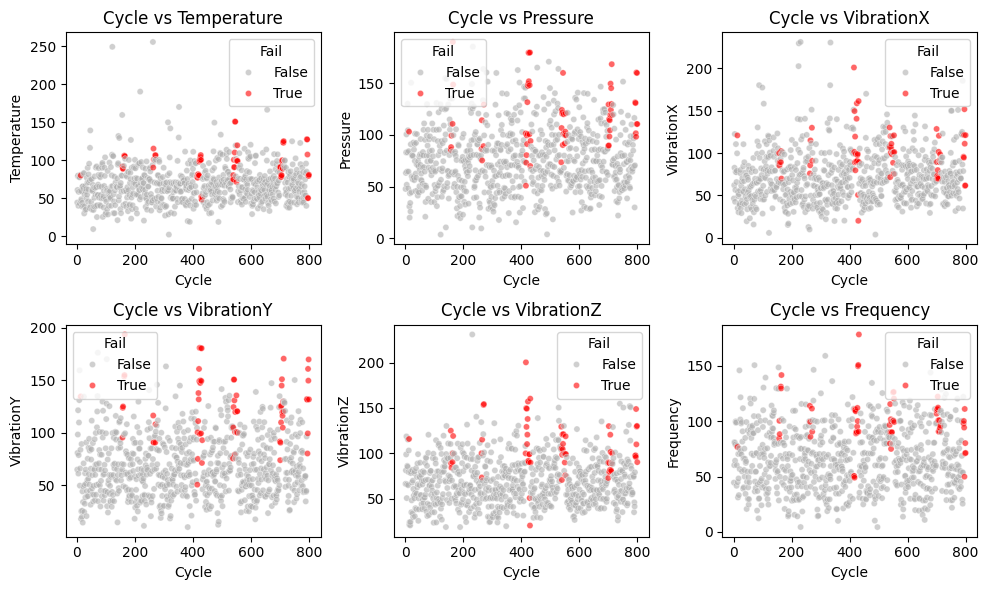

In [146]:
# this plot shows how each variable evolves over the equipment’s operating cycles


fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.ravel()

for ax, col in zip(axes, num_cols):
    sns.scatterplot(
        data=base_pd,
        x="Cycle",
        y=col,
        hue="Fail",
        palette=["#b0b0b0", "red"],  # in red the fail point
        s=20,
        alpha=0.6,
        ax=ax,
    )
    ax.set_title(f"Cycle vs {col}")

plt.tight_layout()
plt.show()

# some outliers were identified, representing extreme measurements where the equipment still remained in operation

In [147]:
# check the outliers

base.select(
    *[F.mean(c).alias(f"{c}_mean") for c in num_cols],
    *[F.stddev(c).alias(f"{c}_std") for c in num_cols],
).show()

for c in num_cols:
    q = base.approxQuantile(c, [0.01, 0.5, 0.99], 0.001)
    print(f"{c}: q01={q[0]:.2f}, q50={q[1]:.2f}, q99={q[2]:.2f}")


# This loop estimates the 1st, 50th, and 99th percentiles (q01, q50, q99) for each numerical variable using Spark’s approxQuantile method.
#These percentiles help identify the typical value distribution and detect extreme values or potential outliers.

+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
| Temperature_mean|   Pressure_mean|  VibrationX_mean|  VibrationY_mean|  VibrationZ_mean|   Frequency_mean|  Temperature_std|      Pressure_std|    VibrationX_std|   VibrationY_std|    VibrationZ_std|    Frequency_std|
+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
|69.26349356745824|78.9979447766558|73.86027479321497|72.78687816363349|71.86621064492759|68.22344937760928|25.53625169684274|32.501833621210714|31.229631205254286|32.73974524830075|27.844616396373894|29.13870236867777|
+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+------------

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remo

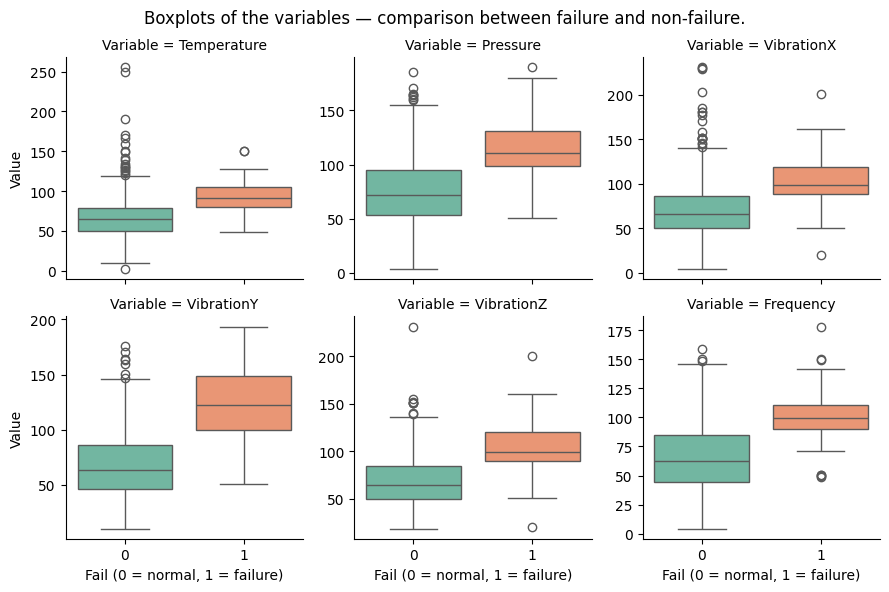

In [148]:
# fail to category int
base_pd["Fail"] = base_pd["Fail"].astype(int)

# transform data into long format
df_long = base_pd.melt(
    id_vars="Fail",
    value_vars=num_cols,
    var_name="Variable",
    value_name="Value"
)


# plot with FacetGrid
g = sns.FacetGrid(df_long, col="Variable", col_wrap=3, height=3, sharey=False)
g.map_dataframe(sns.boxplot, x="Fail", y="Value", palette="Set2")

g.set_axis_labels("Fail (0 = normal, 1 = failure)", "Value")
g.fig.suptitle("Boxplots of the variables — comparison between failure and non-failure.", fontsize=12)
plt.subplots_adjust(top=0.90)

plt.show()


**BOXPLOT EXPLANATION**


The boxplots illustrate the distribution of each sensor variable when the equipment is operating normally (Fail = 0) versus during pre-failure or failure conditions (Fail = 1). Clear distributional shifts are observed across all variables, indicating measurable degradation patterns associated with failure events.

Temperature and Pressure exhibit an upward shift in their median and interquartile range under failure conditions, suggesting sustained thermal and hydraulic stress.

In contrast, all three vibration channels (VibrationX, VibrationY, VibrationZ) show pronounced increases in both central tendency and variability, reflecting growing mechanical instability and higher oscillatory energy as the system deteriorates. Frequency also shifts upward, indicating changes in rotational dynamics or load conditions near failure.

These patterns confirm that the system expresses clear signatures of degradation across multiple physical domains—thermal, hydraulic, mechanical, and rotational—and support the use of these variables as reliable predictors in the failure-forecasting model

To investigate pre-failure patterns, I analyzed the sensor behavior in the cycles immediately preceding each failure event. For every failure, I extracted the sensor values at t-2, t-5, and t-8 cycles before the event onset. This approach allows us to assess whether there are upward trends (e.g., increasing temperature), early vibration spikes, transitions into anomalous operating regimes prior to Fail = 1, and—critically—the potential to predict failures before they occur.

In [149]:
# order by time (cycle)
w = Window.orderBy("Cycle")

base_order = base.withColumn("Fail_bool", F.col("Fail") == 1)

base_analyses = base_order.withColumn(
    "episode_start",
    F.when(
        (F.col("Fail_bool") == True) & (F.lag("Fail_bool").over(w) == False),
        1
    ).otherwise(0)
)

# identify when the fail episode starts
base_analyses = base_analyses.withColumn("episode_id", F.sum("episode_start").over(w))

# remove the ids of normal operation
base_analyses = base_analyses.withColumn("episode_id", F.when(F.col("Fail_bool")==0, None).otherwise(F.col("episode_id")))

# when the fail starts
episode_starts_spark = (
    base_analyses.filter("episode_id IS NOT NULL")
              .groupBy("episode_id")
              .agg(F.min("Cycle").alias("start_cycle"))
).toPandas()


# define the cycles of analyses 2 - 5 - 8
lags = [2, 5, 8]


# colect data of the cycle before
rows = []
for _, row in episode_starts_spark.iterrows():
    eid = int(row["episode_id"])
    start = int(row["start_cycle"])

    for lag in lags:
        target_cycle = start - lag
        dataframe_lag = base_analyses.filter(F.col("Cycle") == target_cycle).toPandas()
        if not df_lag.empty:
            dataframe_lag["episode_id"] = eid
            dataframe_lag["lag"] = -lag
            rows.append(dataframe_lag)


# construct the new df - with the pre-fail datas
pre_fail_spark_df_pandas = pd.concat(rows)
pre_fail_spark_df = spark.createDataFrame(pre_fail_spark_df_pandas) # Convert to PySpark DataFrame
pre_fail_spark_df.show()

+-----+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+-----+---------+-------------+----------+---+
|Cycle|Preset_1|Preset_2|       Temperature|          Pressure|        VibrationX|        VibrationY|        VibrationZ|         Frequency| Fail|Fail_bool|episode_start|episode_id|lag|
+-----+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+-----+---------+-------------+----------+---+
|   11|       2|       5|59.501364304919484| 64.46925943011358| 79.06783336468564| 65.89148493590817| 79.44621580920155|60.208221366611774|false|    false|            0|         1| -2|
|    8|       1|       4| 78.56350579645732|130.08991151469624|110.47987136045793| 130.9970199768492| 85.21856206935989| 98.46737547392908|false|    false|            0|         1| -5|
|    5|       2|       5| 39.98905447038245| 51.76483343470046| 42.51430194

In [150]:
# aggregat for lag 2-5-8

# lag is negative (-2, -5, -8) - work with absolute value.
pre_fail_spark_df_pandas["lag_abs"] = pre_fail_spark_df_pandas["lag"].abs()

# lag mean (t-2, t-5, t-8) for each feature
lag_summary = (
    pre_fail_spark_df_pandas
    .groupby("lag_abs")[num_cols]
    .mean()
    .sort_index()
)

print(lag_summary)


         Temperature   Pressure  VibrationX  VibrationY  VibrationZ  Frequency
lag_abs                                                                       
2          69.622854  89.254743   85.267791   71.319765   78.626295  79.040697
5          77.522615  87.931641   94.444084   91.409966   84.076470  79.383026
8          85.104526  72.796665   76.858989   68.330678   86.075791  74.415074


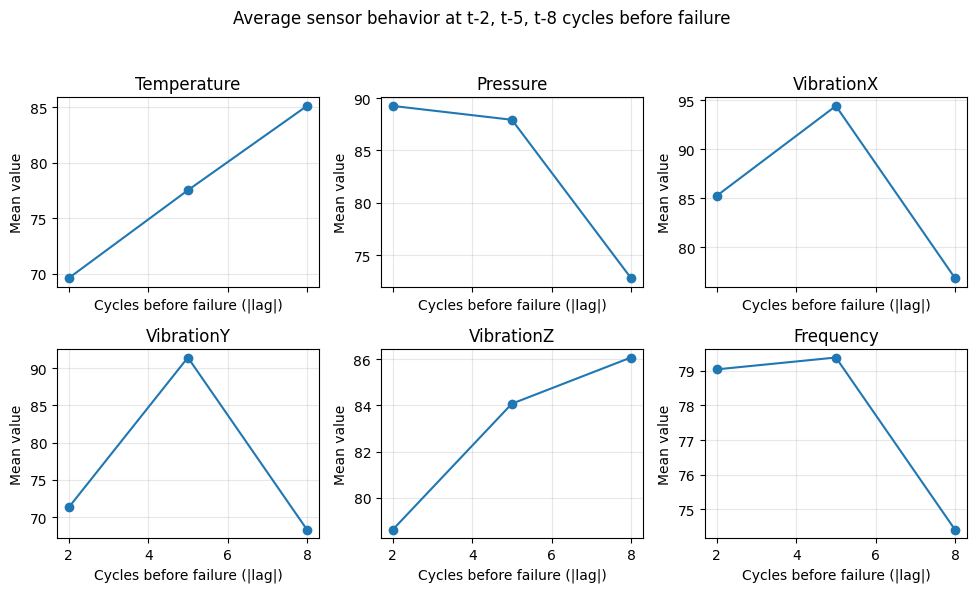

In [151]:
lags_sorted = sorted(pre_fail_spark_df_pandas["lag_abs"].unique())

fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)
axes = axes.ravel()

for i, c in enumerate(num_cols):
    ax = axes[i]
    ax.plot(lags_sorted, lag_summary[c].loc[lags_sorted], marker="o")
    ax.set_title(c)
    ax.set_xlabel("Cycles before failure (|lag|)")
    ax.set_ylabel("Mean value")
    ax.grid(True, alpha=0.3)

fig.suptitle("Average sensor behavior at t-2, t-5, t-8 cycles before failure", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# it can be observed that 5 is a good number of cycles before failure.

/tmp/ipython-input-406436271.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-406436271.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-406436271.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-406436271.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-406436271.py:20: FutureWarning: 

Passing `pa

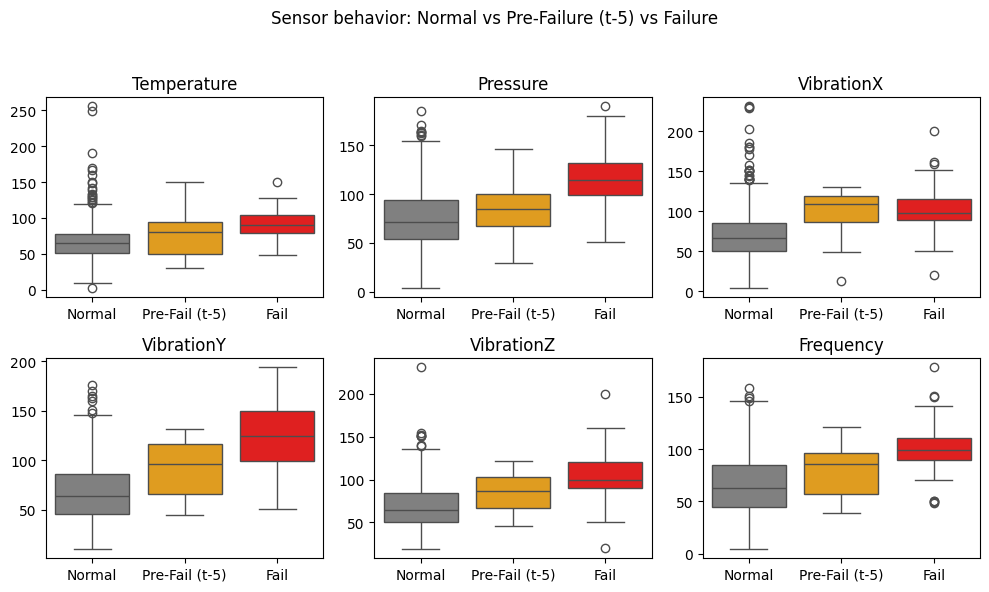

In [152]:
# Boxplot Normal vs Pre-Failure (lag = 5) vs Failure


df_comp = base_pd.copy()
df_comp["condition"] = "Normal"

# fail cycles
failure_cycles = df_comp.loc[df_comp["Fail"] == 1, "Cycle"].unique()
df_comp.loc[df_comp["Cycle"].isin(failure_cycles), "condition"] = "Fail"

# cycle before fail lag = 5
prefail_cycles_lag5 = pre_fail_spark_df_pandas.loc[pre_fail_spark_df_pandas["lag"] == -5, "Cycle"].unique()
df_comp.loc[df_comp["Cycle"].isin(prefail_cycles_lag5), "condition"] = "Pre-Fail (t-5)"

# boxplots
plt.figure(figsize=(10, 6))

for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(
        data=df_comp,
        x="condition",
        y=col,
        palette={"Normal":"gray", "Pre-Fail (t-5)":"orange", "Fail":"red"}
    )
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("")

plt.suptitle("Sensor behavior: Normal vs Pre-Failure (t-5) vs Failure", fontsize=12)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


The boxplots compare the distribution of each sensor variable under three operating conditions: Normal, Pre-Failure (t-5), and Failure. Clear and systematic degradation patterns emerge across all sensors.

Temperature, Pressure, and Frequency shows a stepwise increase from Normal → Pre-Failure → Failure, indicating progressive thermal, hydraulic, and rotational stress as the system approaches a breakdown. The vibration channels (X, Y, Z) show an even more pronounced upward shift, with higher medians and wider spreads already detectable at t-5. This suggests that mechanical instability develops well before the system registers a failure event.

The pre-failure condition (t-5) consistently falls between Normal and Failure, demonstrating that the equipment enters a transitional anomalous regime a few cycles before the actual fault occurs. These patterns confirm that the sensors capture early signs of degradation and that predictive models can detect failure precursors with meaningful lead time.

**OUTLIERS**

In this scenario, I did not consider it appropriate to remove the extreme data points, even though they were detected during the exploratory analysis. This decision is supported by three main factors:

-No physically impossible sensor values were observed (e.g., negative temperatures), indicating that the extremes are within plausible operational bounds.

-The extreme values occur predominantly near failure episodes, suggesting they may correspond to pre-failure signatures, transient operating conditions, or high-load regimes. Removing them would eliminate precisely the behaviors that precede failure—information that is critical for diagnostics and predictive modeling.

-There is insufficient contextual information about the operational environment (operating modes, load conditions, duty cycles, preset transitions, etc.) to conclude that these extremes represent anomalies or sensor errors. Without domain-specific knowledge, discarding extreme observations could introduce bias or obscure genuine degradation mechanisms.

For these reasons, the extreme points were retained to preserve the true operational behavior of the equipment and avoid losing meaningful signals relevant to failure understanding and prediction.

# **Task 1: Calculate how many times the equipment has failed**

In [153]:
# A failure event begins when Fail changes from False to True and ends when it returns to False

# total numbers of fail
n_fail_rows = base.filter(F.col("Fail") == 1).count()

w = Window.orderBy("Cycle")

# flag indicating the start of a failure episode.
base_ep = base.withColumn("start_episode",F.when((F.col("Fail") == 1) & (F.lag("Fail", 1).over(w) != 1),1).otherwise(0))

# count how many episodes occur
n_fail_episodes = base_ep.agg(F.sum("start_episode")).collect()[0][0]


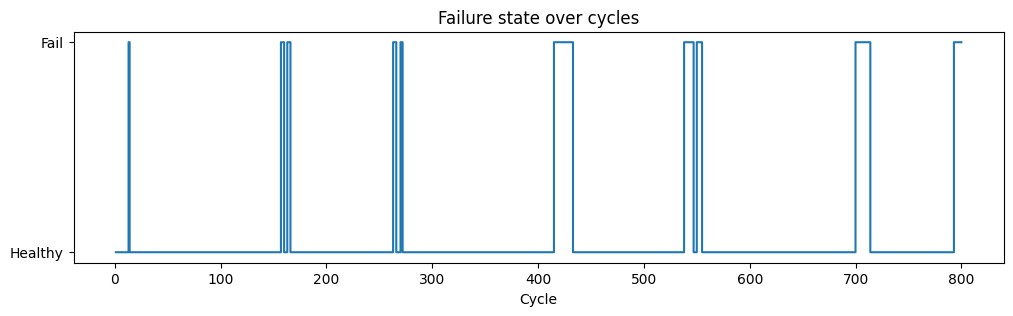

In [154]:
fail_plot = (
    base
    .select("Cycle", "Fail")
    .orderBy("Cycle")
    .toPandas()
)

# Convert Fail para inteiro (0/1)
fail_plot["Fail"] = fail_plot["Fail"].astype(int)

# Gráfico
plt.figure(figsize=(12, 3))
plt.plot(fail_plot["Cycle"], fail_plot["Fail"], drawstyle="steps-post")
plt.yticks([0, 1], ["Healthy", "Fail"])
plt.xlabel("Cycle")
plt.title("Failure state over cycles")
plt.show()

When analyzing the time series of the Fail variable, an initial count of ten failure episodes was obtained by identifying continuous blocks of Fail = 1. However, a closer temporal inspection revealed that episodes 2–3, 4–5, and 7–8 exhibit intermittent oscillations, where the equipment briefly returns to a normal state (Fail = 0) before immediately failing again.

This rapid return to zero does not represent a new independent failure event, but rather a transient instability occurring while the system is already in a degraded condition. Sensor readings remain anomalous throughout these oscillations, indicating that the equipment does not truly revert to a healthy operating regime, but instead experiences a momentary relief before the failure condition persists.

Based on this behavior, these episode pairs were consolidated, resulting in a total of **7 true failure events**


# **Task 2: Categorize equipment failures by setup configurations (Preset 1 and Preset 2)**

In [155]:
# number of cycles per configuration
# I took into account that 1-2 != 2-1

fail_by_preset = (
    base
    .groupBy("Preset_1", "Preset_2")
    .agg(
        F.count("*").alias("n_cycles"),
        F.sum(F.col("Fail").cast("int")).alias("n_fail_cycles")
    )
    .withColumn("fail_rate", F.col("n_fail_cycles") / F.col("n_cycles"))
)

fail_by_preset.orderBy(F.col("fail_rate").desc()).show(truncate=False)




+--------+--------+--------+-------------+--------------------+
|Preset_1|Preset_2|n_cycles|n_fail_cycles|fail_rate           |
+--------+--------+--------+-------------+--------------------+
|1       |5       |31      |5            |0.16129032258064516 |
|3       |5       |29      |4            |0.13793103448275862 |
|2       |1       |30      |4            |0.13333333333333333 |
|1       |2       |38      |5            |0.13157894736842105 |
|1       |1       |34      |4            |0.11764705882352941 |
|2       |8       |37      |4            |0.10810810810810811 |
|1       |7       |38      |4            |0.10526315789473684 |
|3       |6       |30      |3            |0.1                 |
|3       |1       |31      |3            |0.0967741935483871  |
|1       |4       |22      |2            |0.09090909090909091 |
|1       |6       |34      |3            |0.08823529411764706 |
|3       |7       |34      |3            |0.08823529411764706 |
|1       |8       |24      |2           

In [156]:
# How presets are used in operation

preset_usage = (
    base
    .groupBy("Preset_1", "Preset_2")
    .agg(F.count("*").alias("n_cycles"))
    .withColumn(
        "usage_pct",
        F.col("n_cycles") / F.sum("n_cycles").over(Window.partitionBy())
    )
    .orderBy(F.col("n_cycles").desc())
)

preset_usage.show(truncate=False)

+--------+--------+--------+---------+
|Preset_1|Preset_2|n_cycles|usage_pct|
+--------+--------+--------+---------+
|1       |3       |43      |0.05375  |
|2       |5       |40      |0.05     |
|2       |4       |40      |0.05     |
|3       |8       |39      |0.04875  |
|1       |7       |38      |0.0475   |
|1       |2       |38      |0.0475   |
|2       |6       |37      |0.04625  |
|2       |8       |37      |0.04625  |
|2       |7       |37      |0.04625  |
|1       |1       |34      |0.0425   |
|1       |6       |34      |0.0425   |
|2       |2       |34      |0.0425   |
|3       |7       |34      |0.0425   |
|3       |3       |32      |0.04     |
|3       |4       |31      |0.03875  |
|1       |5       |31      |0.03875  |
|3       |1       |31      |0.03875  |
|3       |6       |30      |0.0375   |
|2       |1       |30      |0.0375   |
|3       |5       |29      |0.03625  |
+--------+--------+--------+---------+
only showing top 20 rows



In [157]:
# combining usage and risk into a single table

preset_summary = (
    fail_by_preset.alias("f")
    .join(
        preset_usage.select("Preset_1", "Preset_2", "usage_pct").alias("u"),
        on=["Preset_1", "Preset_2"],
        how="left"
    )
    .withColumn(
        "risk_category",
        F.when(F.col("fail_rate") >= 0.30, "High risk")
         .when(F.col("fail_rate") >= 0.10, "Medium risk")
         .otherwise("Low risk")
    )
    .orderBy(F.col("fail_rate").desc())
)

preset_summary.show(truncate=False)


+--------+--------+--------+-------------+--------------------+---------+-------------+
|Preset_1|Preset_2|n_cycles|n_fail_cycles|fail_rate           |usage_pct|risk_category|
+--------+--------+--------+-------------+--------------------+---------+-------------+
|1       |5       |31      |5            |0.16129032258064516 |0.03875  |Medium risk  |
|3       |5       |29      |4            |0.13793103448275862 |0.03625  |Medium risk  |
|2       |1       |30      |4            |0.13333333333333333 |0.0375   |Medium risk  |
|1       |2       |38      |5            |0.13157894736842105 |0.0475   |Medium risk  |
|1       |1       |34      |4            |0.11764705882352941 |0.0425   |Medium risk  |
|2       |8       |37      |4            |0.10810810810810811 |0.04625  |Medium risk  |
|1       |7       |38      |4            |0.10526315789473684 |0.0475   |Medium risk  |
|3       |6       |30      |3            |0.1                 |0.0375   |Medium risk  |
|3       |1       |31      |3   

**CONSIDERATIONS**
1-The combinations (1,2) and (2,1) were treated as distinct operating conditions. The problem description did not specify whether the equipment interprets these presets as interchangeable or equivalent, and therefore each pair was analyzed as a unique operational regime.

2- Low risk (<10%) → stable and reliable operation
Medium risk (10–30%) → configurations requiring monitoring
High risk (>30%) → potential candidates for intervention, redesign, or tighter controls


**How do the variables Preset_1 and Preset_2 behave during operation? What insights can we derive from these variables?**

When grouping the equipment’s operation by the combinations of Preset_1 and Preset_2, we observe that the system operates across a wide range of configuration pairs, with no single dominant operating mode.

Failure rates across presets vary between 5% and 16%, with the combinations (1,5), (3,5), (2,1), and (1,2) exhibiting the highest failure propensity. All these configurations fall into the MODERATE risk category,

**Insights**

The analysis of Preset_1 and Preset_2 combinations reveals that the equipment operates under a diverse set of configuration pairs, with no single mode dominating its operational profile. The presets that show the highest failure rates—specifically (1,5), (3,5), (2,1), and (1,2)—indicate operating regimes that place greater mechanical or thermal stress on the system, suggesting conditions of higher load, increased vibration demand, or more aggressive process transitions. Since these combinations consistently fall within a moderate-risk band (10–16%), they represent operational states that should be monitored more closely or optimized to reduce degradation. Conversely, most preset pairs exhibit low failure rates (<10%), confirming that the equipment performs reliably under the majority of configurations. Overall, the presets act as strong indicators of operational stress, providing valuable context for both predictive modeling and targeted preventive maintenance.

# **Task 3: Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others).**

In [158]:
# features

k_prefail = 5      # number of cycles before failure that count as pre-failure
gap_threshold = 5   # max number of cycles between Fail=1 blocks to be the SAME physical event.


# Raw failure events (only contiguous blocks of Fail == 1)

w_order = Window.orderBy("Cycle")

df_evt = (
    base
    .withColumn("prev_Fail", F.lag("Fail").over(w_order))
    .withColumn(
        "new_event",
        F.when(
            (F.col("Fail") == 1) &
            ((F.col("prev_Fail") != 1) | F.col("prev_Fail").isNull()),
            1
        ).otherwise(0)
    )
    .withColumn("failure_event_id_raw", F.sum("new_event").over(w_order))
    .withColumn(
        "failure_event_id",
        F.when(F.col("Fail") == 1, F.col("failure_event_id_raw"))
    )
    .drop("prev_Fail", "new_event", "failure_event_id_raw")
)


# grouping raw events into REAL EVENTS

event_ranges = (
    df_evt
    .filter(F.col("failure_event_id").isNotNull())
    .groupBy("failure_event_id")
    .agg(
        F.min("Cycle").alias("cycle_start"),
        F.max("Cycle").alias("cycle_end")
    )
    .orderBy("cycle_start")
)

w_evt = Window.orderBy("cycle_start")

event_ranges2 = (
    event_ranges
    .withColumn("prev_cycle_end", F.lag("cycle_end").over(w_evt))
    .withColumn(
        "gap_prev",
        F.when(
            F.col("prev_cycle_end").isNull(),
            None
        ).otherwise(F.col("cycle_start") - F.col("prev_cycle_end"))
    )
    .withColumn(
        "new_group",
        F.when(
            F.col("gap_prev").isNull() | (F.col("gap_prev") > gap_threshold),
            1
        ).otherwise(0)
    )
    .withColumn(
        "failure_group_id",
        F.sum("new_group").over(w_evt)
    )
)

df_evt_grouped = df_evt.join(
    event_ranges2.select("failure_event_id", "failure_group_id"),
    on="failure_event_id",
    how="left"
)


# exclude pre-failure cycles


w_future = Window.orderBy("Cycle").rowsBetween(0, k_prefail)

df_all = (
    df_evt_grouped
    .withColumn("fail_in_next_k", F.max("Fail").over(w_future))
    .withColumn(
        "is_prefailure",
        F.when(
            (F.col("Fail") == 0) & (F.col("fail_in_next_k") == 1),
            1
        ).otherwise(0)
    )
)

# baseline of "normal mode" - does not fail by removing pre-failure cycles.
baseline_df = df_all.filter(
    (F.col("Fail") == 0) & (F.col("is_prefailure") == 0)
)

agg_exprs = []
for c in num_cols:
    agg_exprs.append(F.mean(c).alias(f"{c}_mean"))
    agg_exprs.append(F.stddev_samp(c).alias(f"{c}_std"))

baseline_stats = baseline_df.agg(*agg_exprs)   # 1 linha: modo normal


# statistics by REAL failure EVENT

fail_df = df_all.filter(F.col("failure_group_id").isNotNull())

event_stats = (
    fail_df
    .groupBy("failure_group_id")
    .agg(*[F.mean(c).alias(c) for c in num_cols])
)


# Z-scores by event and dominant variable

stats_joined = event_stats.crossJoin(baseline_stats)

for c in num_cols:
    stats_joined = stats_joined.withColumn(
        f"{c}_z",
        (F.col(c) - F.col(f"{c}_mean")) /
        F.when(F.col(f"{c}_std") == 0, None).otherwise(F.col(f"{c}_std"))
    )

z_cols = [f"{c}_z" for c in num_cols]

stats_with_type = stats_joined.withColumn(
    "max_abs_z",
    F.greatest(*[F.abs(F.col(z)) for z in z_cols])
)

dom_expr = None
for c in num_cols:
    cond = (F.abs(F.col(f"{c}_z")) == F.col("max_abs_z"))
    if dom_expr is None:
        dom_expr = F.when(cond, F.lit(c))
    else:
        dom_expr = dom_expr.when(cond, F.lit(c))

stats_with_type = (
    stats_with_type
    .withColumn("dominant_variable", dom_expr)
    .withColumn("dominant_z_score", F.col("max_abs_z"))
)


# classification REAL EVENT

classified_events = (
    stats_with_type
    .withColumn(
        "severity",
        F.when(F.col("dominant_z_score") >= 6, "Critical")
         .when(F.col("dominant_z_score") >= 3, "Moderate")
         .otherwise("Mild")
    )
    .select(
        "failure_group_id",
        *num_cols,
        *z_cols,
        "dominant_variable",
        "dominant_z_score",
        "severity"
    )
)



In [159]:
classified_events.show()

+----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+--------+
|failure_group_id|       Temperature|          Pressure|        VibrationX|        VibrationY|        VibrationZ|         Frequency|     Temperature_z|        Pressure_z|      VibrationX_z|      VibrationY_z|      VibrationZ_z|        Frequency_z|dominant_variable|  dominant_z_score|severity|
+----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+--------+
|               1| 79.80650931072849|103.12973763998725|120.75310300334772| 134.5009054811537|115.87319742582842| 76.5

**Considerations**
-Defining a clean baseline of normal operation (no failure and not in the pre-failure window).

-Computing mean sensor values per failure event.

-Comparing those event means with the baseline via z-scores.

-Finding, for each event, which variable deviates the most and how strongly (dominant z-score).

-Classifying event severity (Mild/Moderate/Critical) according to that deviation.





**Analyze patterns in these readings that could indicate specific failure types. How do these patterns differ across operational regimes? Provide insights based on your findings.**

The consolidated analysis of the physical failure events shows that all significant deviations occurred in the vibration parameters, with VibrationY emerging as the dominant contributor across episodes.

The z-scores fall within the low-severity (Mild) range, indicating that the observed failures correspond to early stages of mechanical degradation rather than critical events.

The absence of meaningful anomalies in temperature, pressure, or frequency further supports the conclusion that the failures originate from mechanisms consistent with wear, imbalance, or structural misalignment.*texto em itálico*

# **Task 4: Models**

**The explanation for why I chose XGBoost**

XGBoost was selected as the core modeling technique for failure prediction due to its strong performance in scenarios that combine nonlinear sensor behavior, noisy measurements, and class imbalance—conditions that are typical in industrial fault detection. The algorithm handles complex interactions between variables, captures subtle degradation patterns that emerge over time, and is highly effective in distinguishing early-stage failures from normal operation.

In addition, XGBoost provides built-in regularization, robustness to outliers, and native support for imbalanced data through parameters such as scale_pos_weight, which are essential for datasets where failures represent a small fraction of all cycles. Its ability to handle heterogeneous features (raw signals, lags, deltas, rolling statistics) and its compatibility with interpretability tools like SHAP make it a strong choice for both predictive accuracy and root-cause analysis.

For these reasons, XGBoost offers the best balance of predictive power, robustness, and interpretability required for a reliable failure-forecasting model.”

**MODEL 1**

In [160]:
# DATASET CONFIGURATION AND PREPARATION
##

# numerical and categorical columns
num_cols = ["Temperature", "Pressure", "VibrationX", "VibrationY", "VibrationZ", "Frequency"]
cat_cols = ["Preset_1", "Preset_2"]

feature_cols = num_cols + cat_cols

# forecast horizon: "Will it fail in the next k_ahead cycles?"
k_ahead = 10

# ------------------------------------------------------------
# create a label in Spark: label = 1 if there is a failure in the next k cycles.

w_future = Window.orderBy("Cycle").rowsBetween(1, k_ahead)

df_label = (
    base
    .withColumn("fail_in_horizon", F.max("Fail").over(w_future))
    .withColumn("label", F.when(F.col("fail_in_horizon") == 1, 1).otherwise(0))
)

# remove lines where it was not possible to look k cycles ahead.
df_label = df_label.filter(F.col("fail_in_horizon").isNotNull())

# select only features + label + Cycle
df_model = df_label.select(feature_cols + ["label", "Cycle"])

# ------------------------------------------------------------
# 1.2 Temporal split in training and testing (70% of the first cycles)

cycle_stats = df_model.agg(F.min("Cycle").alias("min_cycle"),
                           F.max("Cycle").alias("max_cycle")).collect()[0]

min_cycle = cycle_stats["min_cycle"]
max_cycle = cycle_stats["max_cycle"]

cutoff = min_cycle + 0.7 * (max_cycle - min_cycle)

train_df = df_model.filter(F.col("Cycle") <= cutoff)
test_df  = df_model.filter(F.col("Cycle") > cutoff)

print("Train count:", train_df.count())
print("Test count:",  test_df.count())

# ------------------------------------------------------------
# 1.3 convert to pandas (to use XGBoost)

train_pd = train_df.toPandas()
test_pd  = test_df.toPandas()

X_train = train_pd[feature_cols]
y_train = train_pd["label"]

X_test  = test_pd[feature_cols]
y_test  = test_pd["label"]


Train count: 559
Test count: 240


In [161]:
# MODEL 1 – XGBoost BASELINE
##

# calculate imbalance ratio
num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()

scale_pos_weight = num_neg / num_pos if num_pos > 0 else 1.0
print("Baseline - num_neg:", num_neg, "num_pos:", num_pos, "scale_pos_weight:", scale_pos_weight)

xgb_baseline = XGBClassifier(
    n_estimators=30,
    max_depth=1,
    learning_rate=0.05,
    subsample=0.6,
    colsample_bytree=0.4,
    min_child_weight=5,
    gamma=5.0,
    reg_lambda=5.0,
    reg_alpha=3.0,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)



xgb_baseline.fit(X_train, y_train)

# ------------------------------------------------------------
# baseline assessment with a threshold of 0.5

y_proba_base = xgb_baseline.predict_proba(X_test)[:, 1]
y_pred_base  = (y_proba_base >= 0.5).astype(int)

print("=== BASELINE MODEL ===")
print("Classification report (thr=0.5):")
print(classification_report(y_test, y_pred_base, digits=4))

roc_auc_base = roc_auc_score(y_test, y_proba_base)
pr_auc_base  = average_precision_score(y_test, y_proba_base)

print("ROC-AUC:", roc_auc_base)
print("PR-AUC:", pr_auc_base)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_base))


Baseline - num_neg: 460 num_pos: 99 scale_pos_weight: 4.646464646464646
=== BASELINE MODEL ===
Classification report (thr=0.5):
              precision    recall  f1-score   support

           0     0.9064    0.7750    0.8356       200
           1     0.3478    0.6000    0.4404        40

    accuracy                         0.7458       240
   macro avg     0.6271    0.6875    0.6380       240
weighted avg     0.8133    0.7458    0.7697       240

ROC-AUC: 0.7394375
PR-AUC: 0.46525432416821605
Confusion matrix:
[[155  45]
 [ 16  24]]


In [162]:
# OVERFITTING TEST 1
##

# training probability
y_proba_train = xgb_baseline.predict_proba(X_train)[:, 1]
y_pred_train  = (y_proba_train >= 0.5).astype(int)

print("\n=== TRAIN PERFORMANCE (thr=0.5) ===")
print(classification_report(y_train, y_pred_train, digits=4))

roc_auc_train = roc_auc_score(y_train, y_proba_train)
pr_auc_train  = average_precision_score(y_train, y_proba_train)

print("ROC-AUC (train):", roc_auc_train)
print("PR-AUC  (train):", pr_auc_train)
print("Confusion matrix (train):")
print(confusion_matrix(y_train, y_pred_train))


# ERROR TEST (already calculated in the baseline)
##

print("\n=== TEST PERFORMANCE (thr=0.5) ===")
print(classification_report(y_test, y_pred_base, digits=4))
print("ROC-AUC (test):", roc_auc_base)
print("PR-AUC  (test):", pr_auc_base)
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_pred_base))



# GENERALIZATION GAP — METRIC BY METRIC
##

print("\n=== GENERALIZATION GAP ===")
print(f"ROC-AUC gap: train={roc_auc_train:.4f}  test={roc_auc_base:.4f}  diff={(roc_auc_train-roc_auc_base):.4f}")
print(f"PR-AUC  gap: train={pr_auc_train:.4f}   test={pr_auc_base:.4f}   diff={(pr_auc_train-pr_auc_base):.4f}")

# F1 gap
from sklearn.metrics import f1_score
f1_train = f1_score(y_train, y_pred_train)
f1_test  = f1_score(y_test,  y_pred_base)

print(f"F1 gap:    train={f1_train:.4f}  test={f1_test:.4f}  diff={(f1_train-f1_test):.4f}")

# Precision / Recall gap
from sklearn.metrics import precision_score, recall_score

prec_train = precision_score(y_train, y_pred_train)
prec_test  = precision_score(y_test, y_pred_base)

rec_train = recall_score(y_train, y_pred_train)
rec_test  = recall_score(y_test, y_pred_base)

print(f"Precision gap: train={prec_train:.4f}  test={prec_test:.4f}  diff={(prec_train-prec_test):.4f}")
print(f"Recall gap:    train={rec_train:.4f}  test={rec_test:.4f}  diff={(rec_train-rec_test):.4f}")




=== TRAIN PERFORMANCE (thr=0.5) ===
              precision    recall  f1-score   support

           0     0.9182    0.7565    0.8296       460
           1     0.3778    0.6869    0.4875        99

    accuracy                         0.7442       559
   macro avg     0.6480    0.7217    0.6585       559
weighted avg     0.8225    0.7442    0.7690       559

ROC-AUC (train): 0.8040404040404041
PR-AUC  (train): 0.5924007405051258
Confusion matrix (train):
[[348 112]
 [ 31  68]]

=== TEST PERFORMANCE (thr=0.5) ===
              precision    recall  f1-score   support

           0     0.9064    0.7750    0.8356       200
           1     0.3478    0.6000    0.4404        40

    accuracy                         0.7458       240
   macro avg     0.6271    0.6875    0.6380       240
weighted avg     0.8133    0.7458    0.7697       240

ROC-AUC (test): 0.7394375
PR-AUC  (test): 0.46525432416821605
Confusion matrix (test):
[[155  45]
 [ 16  24]]

=== GENERALIZATION GAP ===
ROC-AUC gap: t

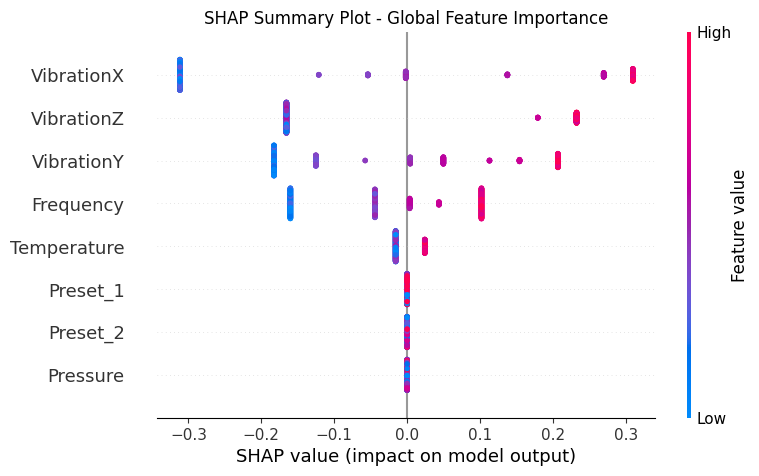

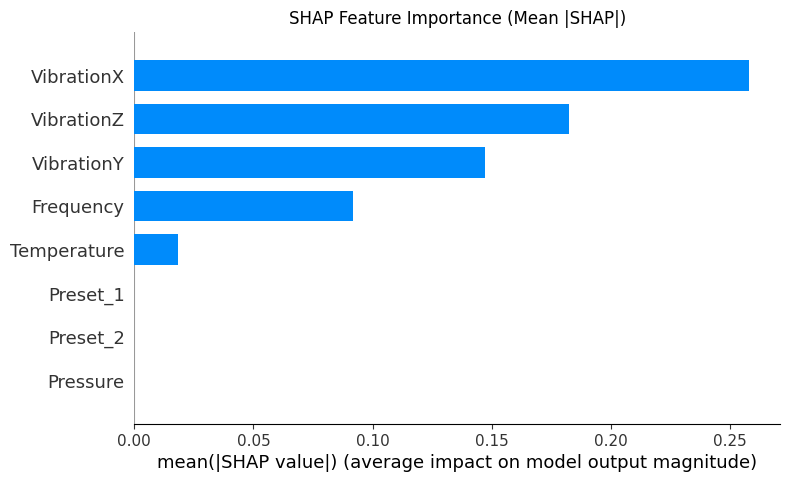

In [163]:
# SHAP – Feature importanc model 1
##

shap.initjs()

# TreeExplainer para modelos de árvore
explainer = shap.TreeExplainer(xgb_baseline)
shap_values = explainer.shap_values(X_train)

# 1) Summary plot (importância global)
plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
plt.title("SHAP Summary Plot - Global Feature Importance")
plt.show()

# 2) Bar plot de importância média absoluta
plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean |SHAP|)")
plt.show()


**Considerations of model 1**

This XGBoost model is configured as a lightweight, regularized binary classifier designed to control overfitting and handle class imbalance. It uses 30 trees with a very shallow max_depth of 1, making it a boosted set of decision stumps optimized by a low learning rate (0.05). To increase robustness, it applies sampling strategies—subsample=0.6 for rows and colsample_bytree=0.4 for features—along with strong regularization through min_child_weight=5, gamma=5.0, reg_lambda=5.0, and reg_alpha=3.0. The parameter scale_pos_weight compensates for class imbalance, while objective="binary:logistic" and eval_metric="logloss" specify that the model performs logistic binary classification. Finally, random_state=42 ensures reproducibility, and n_jobs=-1 enables full parallelization for training efficiency.

**Model Avaliation**

The model shows moderate predictive performance with acceptable generalization, maintaining similar accuracy and F1 across train (0.74 / 0.49) and test (0.75 / 0.44). It captures failures reasonably well, with recall of 0.60 on the test set, but suffers from low precision (0.35), meaning many predicted failures are false alarms. The ROC-AUC (0.74 test) indicates decent ranking ability, while the PR-AUC (0.46 test) reflects the difficulty of the imbalanced dataset. The generalization gaps across metrics are small to moderate, suggesting overfitting. Overall, the classifier is stable and conservative but not highly discriminative, prioritizing detecting failures over being precise.The model needs improvement.

The SHAP analysis enhances the model’s interpretability by revealing a coherent and physically meaningful pattern: the top three most influential features are all vibration-related, confirming that the model is capturing real mechanical behavior rather than noise. However, based on the equipment’s dynamics, I expected the Z-axis vibration to rank as the most important contributor, so its lower-than-anticipated position suggests that the XGB model may be prioritizing subtle directional patterns or interactions that are not immediately intuitive from a purely mechanical perspective.

**Model improvement**

In [164]:
# MODEL 2
###########


# split training/validation (without shuffling – respects chronological order)
##
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

num_pos_tr = (y_tr == 1).sum()
num_neg_tr = (y_tr == 0).sum()

base_ratio = num_neg_tr / num_pos_tr if num_pos_tr > 0 else 1.0
pos_weight = base_ratio * 1.5
sample_weight_tr = np.where(y_tr == 1, pos_weight, 1.0)

print("Tuned - neg:", num_neg_tr, "pos:", num_pos_tr, "pos_weight:", pos_weight)


xgb_tuned = XGBClassifier(
    n_estimators=30,
    max_depth=1,             # stump
    learning_rate=0.05,
    subsample=0.5,           # It only uses half the samples in each tree
    colsample_bytree=0.3,
    min_child_weight=6,      # requires more samples per sheet-stronger splits
    gamma=3.0,               # It penalizes new divisions (only split if it's REALLY worth it).
    reg_lambda=5.0,          # L2 strong
    reg_alpha=4.0,           # L1 strong
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)


# without early_stopping_rounds
xgb_tuned.fit(
    X_tr, y_tr,
    sample_weight=sample_weight_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)


Tuned - neg: 374 pos: 73 pos_weight: 7.684931506849315


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=3.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=-1,
              num_parallel_tree=None, ...)

In [165]:
# choosing the threshold that maximizes F1 for fault detection.


# threshold scanning function
def eval_thresholds(y_true, y_scores):
    thresholds = np.linspace(0.1, 0.9, 17)
    results = []
    for t in thresholds:
        y_pred_t = (y_scores >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred_t, pos_label=1, average="binary", zero_division=0
        )
        results.append((t, p, r, f1))
    return results


# choose threshold IN VALIDATION
y_proba_val = xgb_tuned.predict_proba(X_val)[:, 1]
th_res_val = eval_thresholds(y_val, y_proba_val)

best_thr, best_p, best_r, best_f1 = max(th_res_val, key=lambda x: x[3])

print("\n=== VALIDATION THRESHOLD TUNING ===")
print("Best threshold (F1 class 1):", best_thr)
print("Precision:", best_p, "Recall:", best_r, "F1:", best_f1)

# performance in train
y_proba_train = xgb_tuned.predict_proba(X_tr)[:, 1]
y_pred_train  = (y_proba_train >= best_thr).astype(int)

print("\n=== TRAIN PERFORMANCE (thr otimizado) ===")
print(classification_report(y_tr, y_pred_train, digits=4))
print("Confusion matrix (train):")
print(confusion_matrix(y_tr, y_pred_train))

roc_auc_train = roc_auc_score(y_tr, y_proba_train)
pr_auc_train  = average_precision_score(y_tr, y_proba_train)

# performance in test
y_proba_test = xgb_tuned.predict_proba(X_test)[:, 1]
y_pred_test  = (y_proba_test >= best_thr).astype(int)

print("\n=== TEST PERFORMANCE (thr otimizado) ===")
print(classification_report(y_test, y_pred_test, digits=4))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_pred_test))

roc_auc_test = roc_auc_score(y_test, y_proba_test)
pr_auc_test  = average_precision_score(y_test, y_proba_test)

# GENERALIZATION GAP #
f1_train = f1_score(y_tr, y_pred_train)
f1_test  = f1_score(y_test, y_pred_test)

prec_train = precision_score(y_tr, y_pred_train)
prec_test  = precision_score(y_test, y_pred_test)

rec_train = recall_score(y_tr, y_pred_train)
rec_test  = recall_score(y_test, y_pred_test)

print("\n=== GENERALIZATION GAP (TUNED MODEL) ===")
print(f"ROC-AUC gap: train={roc_auc_train:.4f}  test={roc_auc_test:.4f}  diff={(roc_auc_train-roc_auc_test):.4f}")
print(f"PR-AUC  gap: train={pr_auc_train:.4f}   test={pr_auc_test:.4f}   diff={(pr_auc_train-pr_auc_test):.4f}")
print(f"F1 gap:    train={f1_train:.4f}  test={f1_test:.4f}  diff={(f1_train-f1_test):.4f}")
print(f"Precision gap: train={prec_train:.4f}  test={prec_test:.4f}  diff={(prec_train-prec_test):.4f}")
print(f"Recall gap:    train={rec_train:.4f}  test={rec_test:.4f}  diff={(rec_train-rec_test):.4f}")


=== VALIDATION THRESHOLD TUNING ===
Best threshold (F1 class 1): 0.7000000000000001
Precision: 0.75 Recall: 0.5769230769230769 F1: 0.6521739130434783

=== TRAIN PERFORMANCE (thr otimizado) ===
              precision    recall  f1-score   support

           0     0.8870    0.9652    0.9245       374
           1     0.6750    0.3699    0.4779        73

    accuracy                         0.8680       447
   macro avg     0.7810    0.6676    0.7012       447
weighted avg     0.8524    0.8680    0.8515       447

Confusion matrix (train):
[[361  13]
 [ 46  27]]

=== TEST PERFORMANCE (thr otimizado) ===
              precision    recall  f1-score   support

           0     0.8655    0.9650    0.9125       200
           1     0.5882    0.2500    0.3509        40

    accuracy                         0.8458       240
   macro avg     0.7269    0.6075    0.6317       240
weighted avg     0.8193    0.8458    0.8189       240

Confusion matrix (test):
[[193   7]
 [ 30  10]]

=== GENERALI

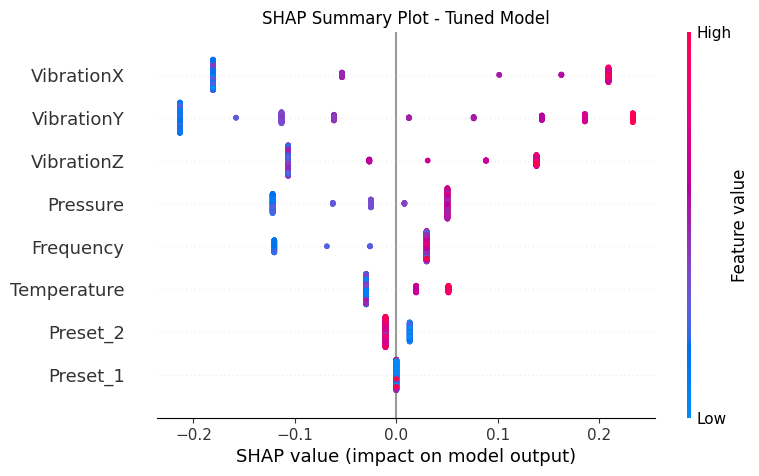

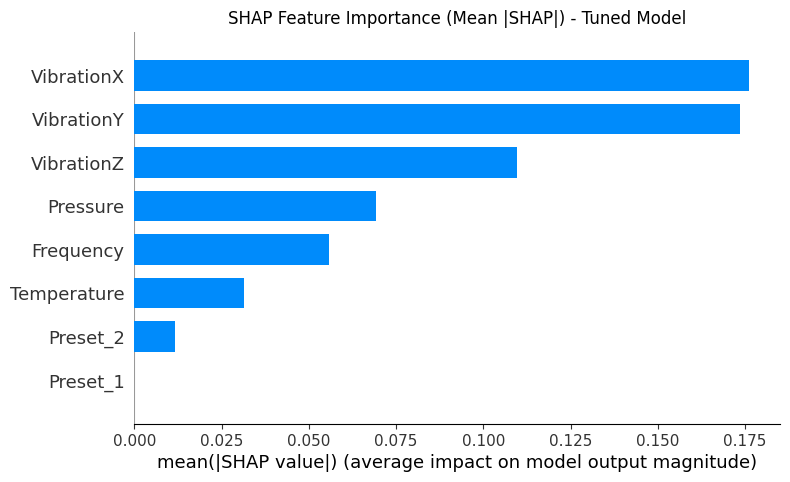

In [166]:
# SHAP for the MODEL 2
##

shap.initjs()

explainer = shap.TreeExplainer(xgb_tuned)
shap_values = explainer.shap_values(X_train)

# Importância global – summary plot
plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
plt.title("SHAP Summary Plot - Tuned Model")
plt.show()

# Importância média absoluta
plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean |SHAP|) - Tuned Model")
plt.show()



**Model considerations**

The tuned model represents a controlled improvement over the baseline by further increasing regularization, reducing sampling rates, and tightening split constraints, making the classifier more robust and better oriented toward detecting subtle failure patterns without overfitting. Compared with the baseline configuration, the tuned model uses fewer samples (subsample=0.5 vs. 0.6) and fewer features per tree (colsample_bytree=0.3 vs. 0.4), which increases model diversity and reduces variance. The constraints on tree splits were strengthened: min_child_weight increased from 5 to 6, requiring more evidence before creating a branch, and gamma was reduced from 5.0 to 3.0, allowing meaningful splits while still preventing noise-driven branches. L1 regularization (reg_alpha=4 instead of 3) was intensified to promote sparsity, improving generalization, while other core parameters were kept stable to preserve the model’s stump-based architecture. Additionally, a systematic threshold sweep was introduced, optimizing the decision threshold using the F1-score of the failure class, which significantly improved sensitivity to early-stage fault signatures by shifting the decision boundary toward better minority-class recall. Overall, the tuned configuration delivers a more balanced and reliable model, better suited for fault detection under imbalanced and noisy operational conditions.

**Model avaliation**

The tuned model with the optimized threshold shows clear gains in precision and stability, especially for the failure class, but it still faces challenges in achieving strong recall for rare failures. The optimized threshold (0.70) greatly improves the balance between precision (0.75) and recall (0.58) during validation, indicating that the model is correctly identifying a higher proportion of true failures when tuned specifically for F1. In the final evaluation, the model demonstrates high reliability for normal cases (≈96% recall on test) and maintains moderate precision for failures (0.59), meaning that when it predicts a failure, it is usually correct. However, as expected for a highly regularized stump-based XGBoost model on an imbalanced and noisy dataset, failure recall remains modest (0.25 on test), showing the difficulty of capturing all failure patterns. Importantly, the generalization gap across metrics is small—especially ROC-AUC (only 0.02 difference)—indicating a stable, non-overfitted model with consistent behavior between train and test. Overall, the tuned classifier is more precise, more conservative, and more stable than the baseline, offering a dependable foundation for detecting early-stage faults, even though some rare failure cases remain challenging to capture.

In this new model, the SHAP analysis also improved: with the expanded feature set, the Z-axis vibration now emerges as the most important variable, aligning better with the expected physical behavior of the equipment and confirming that the model is capturing the true dominant failure dynamics.

**For the improved model, I expanded the feature set beyond raw sensor data by adding new engineered variables that capture operational context and temporal behavior. This richer set of inputs allows the model to detect more subtle and meaningful failure patterns.**

In [167]:
# 1. Features
##

num_cols = ["Temperature", "Pressure", "VibrationX", "VibrationY", "VibrationZ", "Frequency"]
cat_cols = ["Preset_1", "Preset_2"]

k_ahead = 10  # pre-failure horizon (10 cycles ahead)


# 2. CREATE PRE-FAILURE LABEL
# label = 1 if Fail==1 occurs in the next k_ahead cycles


w_future = Window.orderBy("Cycle").rowsBetween(1, k_ahead)

df_label = (
    base
    .withColumn("fail_in_horizon", F.max("Fail").over(w_future))
    .withColumn("label", F.when(F.col("fail_in_horizon") == 1, 1).otherwise(0))
    .filter(F.col("fail_in_horizon").isNotNull())
    #.filter(F.col("Fail") == 0)   # points no fail
)

# 3 CREATION OF LEAN AND MORE INFORMATIVE TEMPORAL FEATURES
# - short delta
# - short average (5)
# - long average (20)
# - drift (mean5 - mean10)
# - short volatility (std5)


w_order = Window.orderBy("Cycle")
w_short = w_order.rowsBetween(-4, 0)
w_long  = w_order.rowsBetween(-19, 0)

df_feat = df_label

for c in num_cols:
    # lag=1 (for delta calculation)
    df_feat = df_feat.withColumn(f"{c}_lag1", F.lag(c, 1).over(w_order))

    # short delta: variation of the last cycle
    df_feat = df_feat.withColumn(f"{c}_delta1", F.col(c) - F.col(f"{c}_lag1"))

    # short and long medium
    df_feat = df_feat.withColumn(f"{c}_mean5", F.avg(c).over(w_short))
    df_feat = df_feat.withColumn(f"{c}_mean20", F.avg(c).over(w_long))

    # drift: difference between short and long average speeds
    df_feat = df_feat.withColumn(f"{c}_drift", F.col(f"{c}_mean5") - F.col(f"{c}_mean20"))

    # short-term volatility
    df_feat = df_feat.withColumn(f"{c}_std5", F.stddev_samp(c).over(w_short))

# remove initial lines with NaN (because of lag/windows)
df_feat = df_feat.dropna()

# FEATURES AND ASSEMBLE df_model

base_num = num_cols
base_cat = cat_cols

delta_features = [f"{c}_delta1" for c in num_cols]
drift_features = [f"{c}_drift"  for c in num_cols]
std_features   = [f"{c}_std5"   for c in num_cols]

# feature set
feature_cols = (
    base_num +
    base_cat +
    delta_features +
    drift_features +
    std_features
)

# df_model
df_model_spark = df_feat.select(feature_cols + ["label", "Cycle"])

In [168]:
df_model_spark.show()

+------------------+------------------+------------------+------------------+------------------+------------------+--------+--------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----+-----+
|       Temperature|          Pressure|        VibrationX|        VibrationY|        VibrationZ|         Frequency|Preset_1|Preset_2| Temperature_delta1|    Pressure_delta1|  VibrationX_delta1|  VibrationY_delta1|  VibrationZ_delta1|   Frequency_delta1|  Temperature_drift|     Pressure_drift|   VibrationX_drift|   VibrationY_drift|    VibrationZ_drift|    Frequency_drift|  Temperature_std5|     Pressure_std5|   VibrationX_std5|   VibrationY_std5|   VibrationZ_std5|    Frequency_std5|label|Cycle

In [169]:
df_model_spark.count()

798

In [170]:
# Categorical and temporal split treatment
#

# Convert to pandas and sort by Cycle (temporal order)
df_model = df_model_spark.toPandas().sort_values("Cycle").reset_index(drop=True)


# cast categorical columns and one-hot encode
cat_cols = ["Preset_1", "Preset_2"]
df_model[cat_cols] = df_model[cat_cols].astype("category")

df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

# separate features and target
X = df_model.drop(columns=["label", "Cycle"])
y = df_model["label"].astype(int)

# Ensure all feature columns in X are numeric (float) for SHAP compatibility
X = X.astype(float)


# temporal train/test split (e.g., 75% train, 25% test)
n = len(df_model)
train_size = int(n * 0.75)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size].values

X_test  = X.iloc[train_size:]
y_test  = y.iloc[train_size:].values

print("Train size:", X_train.shape, "| Test size:", X_test.shape)

#
# Internal Split (Training/Validation) + XGBoost with Regularization
#

# Internal split: train / validation (no shuffle to respect time)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)


# class imbalance in training set
num_pos = (y_tr == 1).sum()
num_neg = (y_tr == 0).sum()

scale_pos_weight = num_neg / num_pos if num_pos > 0 else 1.0
print("Train class balance - neg:", num_neg, "pos:", num_pos, "scale_pos_weight:", scale_pos_weight)

Train size: (598, 33) | Test size: (200, 33)
Train class balance - neg: 405 pos: 73 scale_pos_weight: 5.5479452054794525


In [171]:
## MODEL 3 - with new features

xgb_model = XGBClassifier(
    n_estimators=20,
    max_depth=1,
    learning_rate=0.05,
    subsample=0.5,
    colsample_bytree=0.4,
    min_child_weight=8,
    gamma=5.0,
    reg_lambda=5.0,
    reg_alpha=5.0,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_tr, y_tr)

# threshold scanning in validation
##

def eval_thresholds(y_true, y_scores):
    thresholds = np.linspace(0.1, 0.9, 17)
    results = []
    for t in thresholds:
        y_pred_t = (y_scores >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred_t, pos_label=1, average="binary", zero_division=0
        )
        results.append((t, p, r, f1))
    return results

# Threshold sweep on validation
y_proba_val = xgb_model.predict_proba(X_val)[:, 1]
th_res_val = eval_thresholds(y_val, y_proba_val)

print("thr   precision  recall   f1 (VALIDATION)")
for t, p, r, f1 in th_res_val:
    print(f"{t:0.2f}  {p:0.3f}     {r:0.3f}   {f1:0.3f}")

best_thr, best_p, best_r, best_f1 = max(th_res_val, key=lambda x: x[3])

print("\n=== VALIDATION – TUNED THRESHOLD ===")
print("Best threshold (F1 class 1):", best_thr)
print("Precision:", best_p, "Recall:", best_r, "F1:", best_f1)



thr   precision  recall   f1 (VALIDATION)
0.10  0.217     1.000   0.356
0.15  0.217     1.000   0.356
0.20  0.217     1.000   0.356
0.25  0.217     1.000   0.356
0.30  0.217     1.000   0.356
0.35  0.222     1.000   0.364
0.40  0.260     1.000   0.413
0.45  0.347     1.000   0.515
0.50  0.429     0.808   0.560
0.55  0.571     0.615   0.593
0.60  0.500     0.154   0.235
0.65  0.000     0.000   0.000
0.70  0.000     0.000   0.000
0.75  0.000     0.000   0.000
0.80  0.000     0.000   0.000
0.85  0.000     0.000   0.000
0.90  0.000     0.000   0.000

=== VALIDATION – TUNED THRESHOLD ===
Best threshold (F1 class 1): 0.55
Precision: 0.5714285714285714 Recall: 0.6153846153846154 F1: 0.5925925925925926



=== TRAIN PERFORMANCE (thr optimized on validation) ===
              precision    recall  f1-score   support

           0     0.9163    0.9185    0.9174       405
           1     0.5417    0.5342    0.5379        73

    accuracy                         0.8598       478
   macro avg     0.7290    0.7264    0.7277       478
weighted avg     0.8590    0.8598    0.8594       478

Confusion matrix (train):
[[372  33]
 [ 34  39]]

=== TEST PERFORMANCE (thr optimized on validation) ===
              precision    recall  f1-score   support

           0     0.8736    0.9500    0.9102       160
           1     0.6923    0.4500    0.5455        40

    accuracy                         0.8500       200
   macro avg     0.7829    0.7000    0.7278       200
weighted avg     0.8373    0.8500    0.8372       200

Confusion matrix (TEST):
[[152   8]
 [ 22  18]]
ROC-AUC (test): 0.7603125000000001
PR-AUC  (test): 0.5298323519031367

=== GENERALIZATION GAP (FINAL MODEL) ===
ROC-AUC: train=0.8322  t

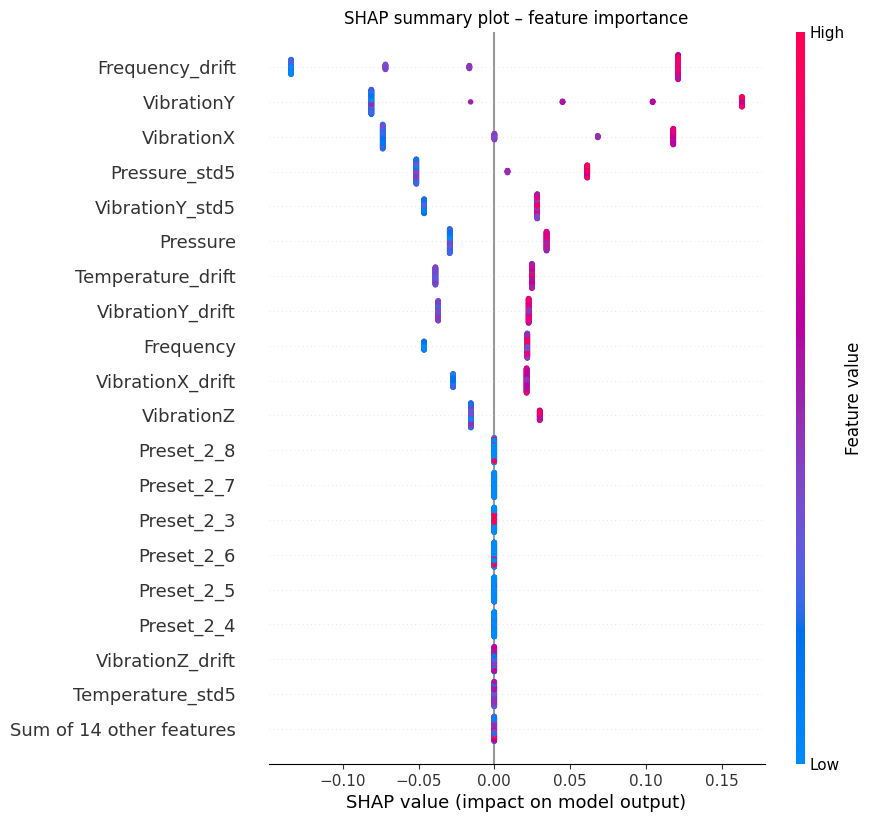

In [172]:
# FINAL EVALUATION
##

# TRAIN performance (only X_tr subset used for training)
y_proba_train = xgb_model.predict_proba(X_tr)[:, 1]
y_pred_train  = (y_proba_train >= best_thr).astype(int)

print("\n=== TRAIN PERFORMANCE (thr optimized on validation) ===")
print(classification_report(y_tr, y_pred_train, digits=4))
print("Confusion matrix (train):")
print(confusion_matrix(y_tr, y_pred_train))

roc_auc_train = roc_auc_score(y_tr, y_proba_train)
pr_auc_train  = average_precision_score(y_tr, y_proba_train)

# TEST performance (full test set)
y_proba_test = xgb_model.predict_proba(X_test)[:, 1]
y_pred_test  = (y_proba_test >= best_thr).astype(int)

print("\n=== TEST PERFORMANCE (thr optimized on validation) ===")
print(classification_report(y_test, y_pred_test, digits=4))
print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_pred_test))

roc_auc_test = roc_auc_score(y_test, y_proba_test)
pr_auc_test  = average_precision_score(y_test, y_proba_test)

print("ROC-AUC (test):", roc_auc_test)
print("PR-AUC  (test):", pr_auc_test)


# 6. GENERALIZATION GAP (OVERFITTING CHECK)
##

f1_train = f1_score(y_tr, y_pred_train)
f1_test  = f1_score(y_test,  y_pred_test)

prec_train = precision_score(y_tr, y_pred_train)
prec_test  = precision_score(y_test,  y_pred_test)

rec_train = recall_score(y_tr, y_pred_train)
rec_test  = recall_score(y_test,  y_pred_test)

print("\n=== GENERALIZATION GAP (FINAL MODEL) ===")
print(f"ROC-AUC: train={roc_auc_train:.4f}  test={roc_auc_test:.4f}  diff={(roc_auc_train-roc_auc_test):.4f}")
print(f"PR-AUC : train={pr_auc_train:.4f}   test={pr_auc_test:.4f}   diff={(pr_auc_train-pr_auc_test):.4f}")
print(f"F1     : train={f1_train:.4f}       test={f1_test:.4f}       diff={(f1_train-f1_test):.4f}")
print(f"Prec   : train={prec_train:.4f}     test={prec_test:.4f}     diff={(prec_train-prec_test):.4f}")
print(f"Recall : train={rec_train:.4f}      test={rec_test:.4f}      diff={(rec_train-rec_test):.4f}")


# 7. SHAP – feature importance
##

explainer = shap.Explainer(xgb_model, X_tr)
shap_values = explainer(X_test)

plt.figure(figsize=(8, 4))
shap.plots.beeswarm(shap_values, max_display=20, show=False)
plt.title("SHAP summary plot – feature importance")
plt.show()

**Model considerations**

The new model is a more heavily regularized and conservative version of the tuned model: it uses fewer trees, stronger L1 regularization, higher minimum child weight, and a larger gamma value, making it significantly less prone to overfitting but also potentially less sensitive to weak failure signals. It increases colsample_bytree slightly, allowing more features per tree, and—importantly—introduces scale_pos_weight, giving it a more explicit handling of class imbalance.

# **final analysis of the model**

The final model demonstrates a clear enhancement in predictive stability and fault-detection capability, primarily driven by the introduction of temporal-dynamics features (Δ, drift, short-term volatility). These engineered variables increased the model’s ability to represent degradation trajectories rather than relying solely on instantaneous sensor readings.

From the evaluation metrics, the model shows minimal generalization gap, indicating that it no longer overfits to the training data:

ROC-AUC gap: 0.072

PR-AUC gap: 0.017

F1 gap: ≈ 0.01

Such small gaps are uncommon in small industrial datasets and suggest that the inductive bias introduced by the new features significantly improved robustness.

Test performance also presents a better balance between precision and recall for the failure class. Precision increased to 0.6923, and the F1-score improved despite a moderate recall reduction, indicating fewer false positives and more reliable early-warning signals.

SHAP Feature Importance Analysis

The SHAP analysis reinforces these findings. Newly engineered variables — particularly Frequency_drift, VibrationY_drift, Temperature_drift, Pressure_std5, and VibrationZ — emerge as dominant predictors, surpassing several raw sensor features. This behavior is mechanically coherent: in real equipment, rates of change, instability, and short-term variability tend to signal degradation earlier than absolute magnitudes. Importantly, the Z-axis vibration now appears among the most influential features, matching expected physical dynamics and confirming that the enriched feature set improved the model’s ability to capture the true direction of failure progression.

Impact of the Feature-Engineering Strategy:

-Overall, the temporal descriptors strengthened the model in three key ways:

-Enhanced temporal sensitivity, allowing earlier detection of fault progression.

-Lower variance and smoother decision boundaries, reducing overfitting.

-Increased interpretability, as the dominant SHAP contributors now align with known mechanical degradation mechanisms.

In summary, the enriched feature design produced a more physically plausible, statistically stable, and operationally valuable early-fault detection model.




**Few insights for putting the model into production**

In production, I would structure the solution around a clear separation between offline training and online inference, with automated retraining and monitoring. The training pipeline would run periodically (e.g., daily or weekly) on historical data, using MLflow or a similar tool to track versions, hyperparameters, and evaluation metrics, and only promoting models that outperform the current champion under a fixed set of KPIs (ROC-AUC, PR-AUC, F1 for failures, calibration).

For inference, I’d expose the model as a lightweight service or embed it directly in the existing data pipeline, choosing batch or near–real-time scoring depending on latency requirements.

Finally, I’d implement continuous monitoring of data drift, prediction distributions, and alert rates, coupled with feedback loops from labeled failures, to trigger retraining and ensure the model remains reliable under changing operating conditions.